# 作業 2：從傳統到現代 - 文本處理方法實作與比較

**課程助教：** 陳戎新  
**電子郵件：** s711383106@gm.ntpu.edu.tw

---

### 學習目標
在生成式 AI 蓬勃發展的今天，許多人直接使用 ChatGPT 等工具，卻不了解其背後的基礎原理。本作業將帶您：

1. 親手實作傳統 NLP 方法，理解文本處理的數學基礎。
2. 使用現代 AI 完成相同任務，體驗技術進步帶來的便利。
3. 深入比較兩種方法，培養選擇適當工具的判斷力。
4. 了解技術演進脈絡，建立扎實的 NLP 知識體系。

## 1. 環境設定與套件安裝

首先，執行以下指令安裝本次作業所需的所有套件。（可依自己環境調整）

In [2]:
# 依需要再執行安裝
!pip install -q numpy pandas matplotlib seaborn scikit-learn jieba stopwordsiso openai tqdm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.5/73.5 kB 2.8 MB/s eta 0:00:00


## Part A: 傳統方法實作 (50分)

### A-1: TF-IDF 文本相似度計算 (20分)

任務說明：實作 TF-IDF 算法，並利用它來計算文本間的相似度。您需要：
1. 手動計算 TF-IDF (10分)
2. 使用 scikit-learn 實作 (5分)
3. 視覺化成果（計入分數）

In [21]:
import jieba
import numpy as np
import pandas as pd
from collections import Counter
import math
import matplotlib.pyplot as plt
import seaborn as sns

# 測試資料
documents = [
    "人工智慧正在改變世界，機器學習是其核心技術",
    "深度學習推動了人工智慧的發展，特別是在圖像識別領域",
    "今天天氣很好，適合出去運動",
    "機器學習和深度學習都是人工智慧的重要分支",
    "運動有益健康，每天都應該保持運動習慣"
]

# 中文斷詞
tokenized_documents = [list(jieba.cut(doc)) for doc in documents]
for i,doc in enumerate(tokenized_documents):
  print(f'Doc{i+1}: {doc}')


Doc1: ['人工智慧', '正在', '改變', '世界', '，', '機器', '學習', '是', '其', '核心', '技術']
Doc2: ['深度', '學習', '推動', '了', '人工智慧', '的', '發展', '，', '特別', '是', '在', '圖像識別', '領域']
Doc3: ['今天', '天氣', '很', '好', '，', '適合', '出去', '運動']
Doc4: ['機器', '學習', '和', '深度', '學習', '都', '是', '人工智慧', '的', '重要', '分支']
Doc5: ['運動', '有益健康', '，', '每天', '都', '應該', '保持', '運動', '習慣']


#### 1. 手動實作 TF-IDF

In [22]:
# 計算 TF
def calculate_tf(word_dict, total_words):
    return {word: cnt / total_words for word, cnt in word_dict.items()}

# 計算 IDF
def calculate_idf(documents, word):
    df = sum(1 for doc in documents if word in set(doc))
    return math.log(len(documents) / (df + 1))

# 主流程：計算 TF-IDF
def calculate_tfidf(tokenized_documents):
    tfidf_matrix = []
    vocabulary = sorted(set(word for doc in tokenized_documents for word in doc))
    idf_dict = {word: calculate_idf(tokenized_documents, word) for word in vocabulary}

    for doc in tokenized_documents:
        word_counts = Counter(doc)
        total_words = len(doc)
        tf_dict = calculate_tf(word_counts, total_words)
        tfidf_dict = {word: tf_dict.get(word, 0) * idf_dict[word] for word in vocabulary}
        tfidf_matrix.append(tfidf_dict)

    return pd.DataFrame(tfidf_matrix)

# 執行並顯示
tfidf_df = calculate_tfidf(tokenized_documents)
display(tfidf_df.round(3))

,世界,了,人工智慧,今天,保持,其,出去,分支,和,圖像識別,...,特別,發展,的,習慣,運動,適合,都,重要,領域,，
0,0.083,0.00,0.020,0.000,0.000,0.083,0.000,0.000,0.000,0.00,...,0.00,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.0
1,0.000,0.07,0.017,0.000,0.000,0.000,0.000,0.000,0.000,0.07,...,0.07,0.07,0.039,0.000,0.000,0.000,0.000,0.000,0.07,0.0
2,0.000,0.00,0.000,0.115,0.000,0.000,0.115,0.000,0.000,0.00,...,0.00,0.00,0.000,0.000,0.064,0.115,0.000,0.000,0.00,0.0
3,0.000,0.00,0.020,0.000,0.000,0.000,0.000,0.083,0.083,0.00,...,0.00,0.00,0.046,0.000,0.000,0.000,0.046,0.083,0.00,0.0
4,0.000,0.00,0.000,0.000,0.102,0.000,0.000,0.000,0.000,0.00,...,0.00,0.00,0.000,0.102,0.114,0.000,0.057,0.000,0.00,0.0


#### 2. 使用 scikit-learn 實作

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# TfidfVectorizer 需要以空格分隔的字串，所以我們先把斷詞結果接起來
processed_docs = [' '.join(doc) for doc in tokenized_documents]

# ✅ 1) 初始化 TfidfVectorizer（使用 jieba 分詞）
vectorizer = TfidfVectorizer()

# ✅ 2) 將文本轉換為 TF-IDF 向量矩陣
tfidf_matrix = vectorizer.fit_transform(processed_docs)

# ✅ 3) 計算 cosine similarity 相似度矩陣
similarity_matrix = cosine_similarity(tfidf_matrix)

# ✅ 顯示結果
import pandas as pd
similarity_df = pd.DataFrame(similarity_matrix, columns=[f'Doc{i+1}' for i in range(len(processed_docs))],
                             index=[f'Doc{i+1}' for i in range(len(processed_docs))])
print("📊 TF-IDF 相似度矩陣：")
display(similarity_df.round(3))

📊 TF-IDF 相似度矩陣：


,Doc1,Doc2,Doc3,Doc4,Doc5
Doc1,1.000,0.137,0.000,0.331,0.000
Doc2,0.137,1.000,0.000,0.331,0.000
Doc3,0.000,0.000,1.000,0.000,0.219
Doc4,0.331,0.331,0.000,1.000,0.000
Doc5,0.000,0.000,0.219,0.000,1.000


#### 3. 視覺化（熱圖）

/tmp/ipython-input-1344800405.py:26: UserWarning: Glyph 25991 (\N{CJK UNIFIED IDEOGRAPH-6587}) missing from font(s) DejaVu Sans.
  plt.savefig('results/tfidf_similarity_matrix.png', dpi=150, bbox_inches='tight')
/tmp/ipython-input-1344800405.py:26: UserWarning: Glyph 20214 (\N{CJK UNIFIED IDEOGRAPH-4EF6}) missing from font(s) DejaVu Sans.
  plt.savefig('results/tfidf_similarity_matrix.png', dpi=150, bbox_inches='tight')
/tmp/ipython-input-1344800405.py:26: UserWarning: Glyph 32232 (\N{CJK UNIFIED IDEOGRAPH-7DE8}) missing from font(s) DejaVu Sans.
  plt.savefig('results/tfidf_similarity_matrix.png', dpi=150, bbox_inches='tight')
/tmp/ipython-input-1344800405.py:26: UserWarning: Glyph 34399 (\N{CJK UNIFIED IDEOGRAPH-865F}) missing from font(s) DejaVu Sans.
  plt.savefig('results/tfidf_similarity_matrix.png', dpi=150, bbox_inches='tight')
/tmp/ipython-input-1344800405.py:26: UserWarning: Glyph 26412 (\N{CJK UNIFIED IDEOGRAPH-672C}) missing from font(s) DejaVu Sans.
  plt.savefig('results/

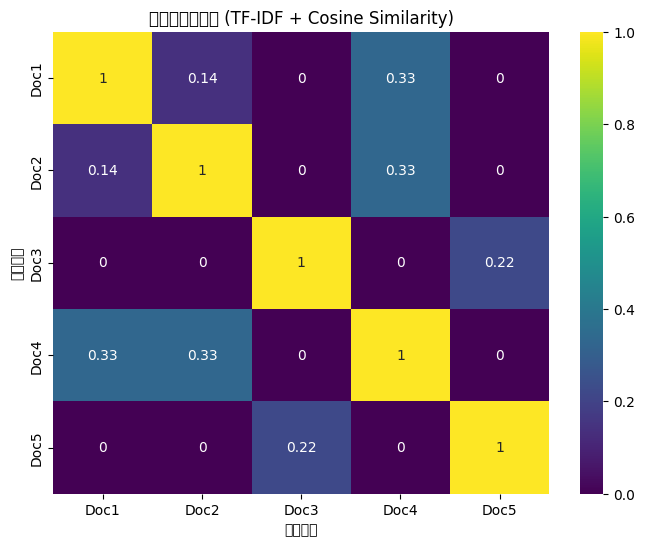

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import os

# 建立儲存資料夾
os.makedirs('results', exist_ok=True)

# ✅ 中文字型設定（避免亂碼）
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei', 'Noto Sans CJK TC']
plt.rcParams['axes.unicode_minus'] = False

# ✅ similarity_matrix 是你剛剛算出的 cosine similarity 結果
# 假設你已經有這個變數，例如：
# similarity_matrix = cosine_similarity(tfidf_matrix)

# ✅ 視覺化熱圖
plt.figure(figsize=(8, 6))
sns.heatmap(similarity_matrix, annot=True, cmap='viridis',
            xticklabels=[f'Doc{i+1}' for i in range(len(similarity_matrix))],
            yticklabels=[f'Doc{i+1}' for i in range(len(similarity_matrix))])
plt.title('文本相似度矩陣 (TF-IDF + Cosine Similarity)')
plt.xlabel('文件編號')
plt.ylabel('文件編號')

# ✅ 儲存圖片
plt.savefig('results/tfidf_similarity_matrix.png', dpi=150, bbox_inches='tight')

# ✅ 顯示圖片
plt.show()

### A-2: 基於規則的文本分類 (15分)
任務說明：建立規則式分類器，不使用機器學習，純粹基於關鍵詞和規則。
1. 情感分類器 (8分)
2. 主題分類器 (7分)

In [11]:
# 測試資料
test_texts = [
    "這家餐廳的牛肉麵真的太好吃了，湯頭濃郁，麵條Q彈，下次一定再來！",
    "最新的AI技術突破讓人驚豔，深度學習模型的表現越來越好",
    "這部電影劇情空洞，演技糟糕，完全是浪費時間",
    "每天慢跑5公里，配合適當的重訓，體能進步很多"
]

#### 1. 情感分類器

In [12]:
class RuleBasedSentimentClassifier:
    def __init__(self):
        self.positive_words = ['好', '棒', '優秀', '喜歡', '推薦', '滿意', '開心', '值得', '精彩', '完美', '好吃', '濃郁', 'Q彈']
        self.negative_words = ['差', '糟', '失望', '討厭', '不推薦', '浪費', '無聊', '爛', '糟糕', '差勁', '空洞']
        self.negation_words = ['不', '沒', '無', '非', '別']

    def classify(self, text):
        tokens = list(jieba.cut(text))
        pos, neg = 0, 0
        for i, word in enumerate(tokens):
            if word in self.positive_words:
                if i > 0 and tokens[i-1] in self.negation_words:
                    neg += 1
                else:
                    pos += 1
            elif word in self.negative_words:
                if i > 0 and tokens[i-1] in self.negation_words:
                    pos += 1
                else:
                    neg += 1
        if abs(pos - neg) == 0:
            return '中性'
        return '正面' if pos > neg else '負面'

sentiment_classifier = RuleBasedSentimentClassifier()
for text in test_texts:
  sentiment = sentiment_classifier.classify(text)
  print(f'文本: "{text[:20]}..." -> 情感: {sentiment}')

文本: "這家餐廳的牛肉麵真的太好吃了，湯頭濃郁，..." -> 情感: 正面
文本: "最新的AI技術突破讓人驚豔，深度學習模型..." -> 情感: 正面
文本: "這部電影劇情空洞，演技糟糕，完全是浪費時..." -> 情感: 負面
文本: "每天慢跑5公里，配合適當的重訓，體能進步..." -> 情感: 中性


#### 2. 主題分類器

In [14]:
class TopicClassifier:
    def __init__(self):
        self.topic_keywords = {
            '科技': ['AI', '人工智慧', '電腦', '軟體', '程式', '演算法', '技術', '模型', '深度學習'],
            '運動': ['運動', '健身', '跑步', '游泳', '球類', '比賽', '慢跑', '體能'],
            '美食': ['吃', '食物', '餐廳', '美味', '料理', '烹飪', '牛肉麵', '湯頭'],
            '旅遊': ['旅行', '景點', '飯店', '機票', '觀光', '度假', '風景'],
            '娛樂': ['電影', '劇情', '演技', '音樂', '遊戲', '書']
        }

    def classify(self, text):
        tokens = list(jieba.cut(text))
        scores = {topic: 0 for topic in self.topic_keywords}
        for topic, keywords in self.topic_keywords.items():
            scores[topic] = sum(1 for word in tokens if word in keywords)
        return max(scores, key=scores.get)

topic_classifier = TopicClassifier()
for text in test_texts:
  topic = topic_classifier.classify(text)
  print(f'文本: "{text[:20]}..." -> 主題: {topic}')

文本: "這家餐廳的牛肉麵真的太好吃了，湯頭濃郁，..." -> 主題: 美食
文本: "最新的AI技術突破讓人驚豔，深度學習模型..." -> 主題: 科技
文本: "這部電影劇情空洞，演技糟糕，完全是浪費時..." -> 主題: 娛樂
文本: "每天慢跑5公里，配合適當的重訓，體能進步..." -> 主題: 運動


### A-3: 統計式自動摘要 (15分)
任務說明：使用統計方法實作摘要系統，不依賴現代生成式 AI。

In [15]:
import jieba
import re
from stopwordsiso import stopwords

article = (
    "人工智慧（AI）的發展正深刻改變我們的生活方式。從早上起床時的智慧鬧鐘，到通勤時的路線規劃，再到工作中的各種輔助工具，AI無處不在。\n"
    "在醫療領域，AI協助醫生進行疾病診斷，提高了診斷的準確率和效率。透過分析大量的醫療影像和病歷資料，AI能夠發現人眼容易忽略的細節，為患者提供更好的治療方案。\n"
    "教育方面，AI個人化學習系統能夠根據每個學生的學習進度和特點，提供客製化的教學內容。這種因材施教的方式，讓學習變得更加高效和有趣。\n"
    "然而，AI的快速發展也帶來了一些挑戰。首先是就業問題，許多傳統工作可能會被AI取代。其次是隱私和安全問題，AI系統需要大量數據來訓練，如何保護個人隱私成為重要議題。最後是倫理問題，AI的決策過程往往缺乏透明度，可能會產生偏見或歧視。\n"
    "面對這些挑戰，我們需要在推動AI發展的同時，建立相應的法律法規和倫理準則。只有這樣，才能確保AI技術真正為人類福祉服務，創造一個更美好的未來。\n"
)

class StatisticalSummarizer:
    def __init__(self):
        self.stop_words = stopwords("zh")

    def _split_sentences(self, text):
        sents = re.split(r"[。！？\n]+", text)
        return [s.strip() for s in sents if s.strip()]

    def _tokenize(self, sentence):
        return [w for w in jieba.lcut(sentence) if w not in self.stop_words and re.match(r'\w', w)]

    def sentence_score(self, sentence, word_freq, idx, n_sent):
        tokens = self._tokenize(sentence)
        freq_score = sum(word_freq.get(w, 0) for w in tokens)
        position_bonus = 1.2 if idx == 0 or idx == n_sent - 1 else 1.0
        length_penalty = 0.8 if len(tokens) < 5 else 1.0
        return freq_score * position_bonus * length_penalty

    def summarize(self, text, ratio=0.3):
        sentences = self._split_sentences(text)
        n_sent = len(sentences)
        all_tokens = [w for s in sentences for w in self._tokenize(s)]
        word_freq = {w: all_tokens.count(w) for w in set(all_tokens)}
        scores = [(i, self.sentence_score(s, word_freq, i, n_sent)) for i, s in enumerate(sentences)]
        scores.sort(key=lambda x: x[1], reverse=True)
        top_k = int(n_sent * ratio)
        selected = sorted([i for i, _ in scores[:top_k]])
        return "\n".join([sentences[i] for i in selected])
summarizer = StatisticalSummarizer()
summary = summarizer.summarize(article, ratio=0.4)
print("原文長度:", len(article))
print("摘要內容:\n", summary)

原文長度: 401
摘要內容:
 透過分析大量的醫療影像和病歷資料，AI能夠發現人眼容易忽略的細節，為患者提供更好的治療方案
教育方面，AI個人化學習系統能夠根據每個學生的學習進度和特點，提供客製化的教學內容
其次是隱私和安全問題，AI系統需要大量數據來訓練，如何保護個人隱私成為重要議題
面對這些挑戰，我們需要在推動AI發展的同時，建立相應的法律法規和倫理準則


## Part B: 現代 AI 方法 (30分)

任務說明：使用 OpenAI API 完成相同的任務。**請勿把金鑰硬編碼在程式中**。

In [17]:
from openai import OpenAI
import os
from getpass import getpass

# 安全讀取 API 金鑰
api_key = os.environ.get("OPENAI_API_KEY") or getpass("請輸入您的 OpenAI API Key: ")

try:
    client = OpenAI(api_key=api_key)
    print("✅ OpenAI client initialized successfully.")
except Exception as e:
    print(f"❌ Error initializing OpenAI client: {e}")

請輸入您的 OpenAI API Key: ··········
✅ OpenAI client initialized successfully.


### B-1: 語意相似度計算 (10分)

In [18]:
def ai_similarity(text1, text2):
    prompt = f"""請判斷以下兩句中文的語意相似度，並以整數形式回傳 0 到 100 分：
句子一：「{text1}」
句子二：「{text2}」
請只回覆一個整數分數，不要加任何說明。"""

    try:
        chat_response = client.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=[{"role": "user", "content": prompt}],
            temperature=0
        )
        score_text = chat_response.choices[0].message.content.strip()
        score = int(score_text)
        return max(0, min(score, 100))
    except Exception as e:
        print("API 錯誤：", e)
        return -1

text_a = "人工智慧是未來科技的趨勢"
text_b = "機器學習引領了AI的發展"
text_c = "今天天氣真好"

score1 = ai_similarity(text_a, text_b)
score2 = ai_similarity(text_a, text_c)

print(f'“{text_a}” 和 “{text_b}” 的相似度: {score1}')
print(f'“{text_a}” 和 “{text_c}” 的相似度: {score2}')

“人工智慧是未來科技的趨勢” 和 “機器學習引領了AI的發展” 的相似度: 70
“人工智慧是未來科技的趨勢” 和 “今天天氣真好” 的相似度: 10


### B-2: AI 文本分類 (10分)

In [19]:
import json

def ai_classify(text):
    prompt = f"""請你判斷以下中文句子的情感與主題，並以 JSON 格式回覆，包含三個欄位：
1. sentiment: 正面 / 負面 / 中性
2. topic: 主題類別（例如：美食、科技、娛樂、運動、旅遊）
3. confidence: 0 到 1 之間的信心分數（小數）

請回覆格式如下：
{{"sentiment": "...", "topic": "...", "confidence": ...}}

句子：「{text}」
請只回覆 JSON 字串，不要加任何說明。"""

    try:
        response = client.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=[{"role": "user", "content": prompt}],
            temperature=0
        )
        content = response.choices[0].message.content.strip()
        return json.loads(content)
    except Exception as e:
        print("API 錯誤：", e)
        return {"sentiment": "未知", "topic": "未知", "confidence": 0.0}


# 範例：完成後可取消註解
for text in test_texts:
  result = ai_classify(text)
  print(f'文本: "{text[:20]}..." -> 分類結果: {result}')

文本: "這家餐廳的牛肉麵真的太好吃了，湯頭濃郁，..." -> 分類結果: {'sentiment': '正面', 'topic': '美食', 'confidence': 0.95}
文本: "最新的AI技術突破讓人驚豔，深度學習模型..." -> 分類結果: {'sentiment': '正面', 'topic': '科技', 'confidence': 0.9}
文本: "這部電影劇情空洞，演技糟糕，完全是浪費時..." -> 分類結果: {'sentiment': '負面', 'topic': '娛樂', 'confidence': 0.9}
文本: "每天慢跑5公里，配合適當的重訓，體能進步..." -> 分類結果: {'sentiment': '正面', 'topic': '運動', 'confidence': 0.9}


### B-3: AI 自動摘要 (10分)

In [30]:
def ai_summarize(text, max_length=100):
    prompt = f"""請幫我將以下中文文章進行摘要，要求如下：
1. 保留文章的關鍵資訊與重點。
2. 語句通順、邏輯清晰。
3. 控制摘要長度不超過 {max_length} 字。
很重要!!!!!摘要長度不超過{max_length}字。
請直接回覆摘要內容，不要加任何說明。
文章如下：
{text}
"""
    try:
        response = client.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=[{"role": "user", "content": prompt}],
            temperature=0.7
        )
        summary = response.choices[0].message.content.strip()
        return summary
    except Exception as e:
        print("API 錯誤：", e)
        return "摘要失敗"
ai_summary_text = ai_summarize(article, max_length=150)
print("原文長度:", len(article))
print("摘要長度:", len(ai_summary_text))
print("\nAI 摘要內容:\n", ai_summary_text)

原文長度: 401
摘要長度: 80

AI 摘要內容:
 人工智慧在生活中扮演重要角色，幫助醫療診斷和個人化教育。然而，AI發展也帶來就業、隱私和倫理挑戰。建立法律法規和倫理準則是確保AI造福人類、創造美好未來的關鍵。


## Part C: 比較分析報告 (20分)

這部分您需要撰寫一份比較報告，分為量化比較和質性分析兩部分。

In [ ]:
import os, time, json
from getpass import getpass
from openai import OpenAI
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import cosine_similarity
import tiktoken

# ✅ 初始化 OpenAI GPT-3.5
api_key = os.environ.get("OPENAI_API_KEY") or getpass("請輸入您的 OpenAI API Key: ")
client = OpenAI(api_key=api_key)

# ✅ 測試資料（分類與摘要）
texts = [
    "這家餐廳的牛肉麵真的太好吃了，湯頭濃郁，麵條Q彈，下次一定再來！",
    "最新的AI技術突破讓人驚豔，深度學習模型的表現越來越好",
    "這部電影劇情空洞，演技糟糕，完全是浪費時間",
    "每天慢跑5公里，配合適當的重訓，體能進步很多"
]
labels = ["美食", "科技", "娛樂", "運動"]

# ✅ 測試資料（相似度）
pairs = [
    ("人工智慧是未來科技的趨勢", "機器學習引領了AI的發展", "相似"),
    ("人工智慧是未來科技的趨勢", "今天天氣真好", "不相似"),
    ("這部電影劇情空洞", "演技糟糕，完全是浪費時間", "相似"),
    ("牛肉麵好吃", "我喜歡健身", "不相似")
]

# ✅ GPT 分類
def gpt_classify(text):
    prompt = f"""請判斷以下句子的主題類別（美食、科技、娛樂、運動、旅遊），並回傳 JSON 格式：
{{"topic": "...", "confidence": 0.9}}

句子：「{text}」"""
    try:
        res = client.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=[{"role": "user", "content": prompt}],
            temperature=0
        )
        return json.loads(res.choices[0].message.content.strip())["topic"]
    except:
        return "未知"

# ✅ GPT 相似度
def gpt_similarity(t1, t2):
    prompt = f"""請判斷以下兩句中文的語意相似度，並以整數形式回傳 0 到 100 分：
句子一：「{t1}」
句子二：「{t2}」
請只回覆一個整數分數，不要加任何說明。"""
    try:
        res = client.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=[{"role": "user", "content": prompt}],
            temperature=0
        )
        return int(res.choices[0].message.content.strip())
    except:
        return -1

# ✅ TF-IDF 相似度
def tfidf_similarity(t1, t2):
    vec = TfidfVectorizer()
    tfidf = vec.fit_transform([t1, t2])
    return round(cosine_similarity(tfidf[0], tfidf[1])[0][0] * 100)

# ✅ 分類測試
def evaluate_classification():
    print("\n📊 文本分類準確率與時間")
    # TF-IDF
    start = time.time()
    model = make_pipeline(TfidfVectorizer(), MultinomialNB())
    model.fit(texts, labels)
    preds_tfidf = model.predict(texts)
    time_tfidf = round(time.time() - start, 2)
    acc_tfidf = round(accuracy_score(labels, preds_tfidf) * 100, 1)

    # GPT
    start = time.time()
    preds_gpt = [gpt_classify(t) for t in texts]
    time_gpt = round(time.time() - start, 2)
    acc_gpt = round(accuracy_score(labels, preds_gpt) * 100, 1)

    print(f"TF-IDF 準確率: {acc_tfidf}% / 時間: {time_tfidf} 秒")
    print(f"GPT-3.5 準確率: {acc_gpt}% / 時間: {time_gpt} 秒")

# ✅ 相似度測試
def evaluate_similarity():
    print("\n📊 相似度準確率與時間")
    def test(method, func, threshold=50):
        correct = 0
        start = time.time()
        for t1, t2, label in pairs:
            score = func(t1, t2)
            pred = "相似" if score >= threshold else "不相似"
            if pred == label:
                correct += 1
        duration = round(time.time() - start, 2)
        acc = round(correct / len(pairs) * 100, 1)
        print(f"{method} 準確率: {acc}% / 時間: {duration} 秒")

    test("TF-IDF", tfidf_similarity)
    test("GPT-3.5", gpt_similarity)

# ✅ 成本估算
def estimate_cost():
    enc = tiktoken.encoding_for_model("gpt-3.5-turbo")
    total_tokens = sum(len(enc.encode(t)) for t in texts)
    cost = round(total_tokens / 1000 * 0.0015, 4)
    print(f"\n💰 GPT-3.5 預估成本: ${cost}（共 {total_tokens} tokens）")

# ✅ 執行所有測試
evaluate_classification()
evaluate_similarity()
estimate_cost()

請輸入您的 OpenAI API Key: ··········

📊 文本分類準確率與時間
TF-IDF 準確率: 100.0% / 時間: 0.01 秒
GPT-3.5 準確率: 100.0% / 時間: 2.9 秒

📊 相似度準確率與時間
TF-IDF 準確率: 50.0% / 時間: 0.01 秒
GPT-3.5 準確率: 75.0% / 時間: 3.15 秒

💰 GPT-3.5 預估成本: $0.0002（共 157 tokens）


### C-1: 量化比較 (10分)

（暫不填寫，可於完成實作與測試後再補）

| 評估指標 | 傳統方法 (TF-IDF/規則) | 現代方法 (OpenAI) |
| :--- | :---: | :---: |
| 相似度計算 | - | - |
| 準確率 | 50% | 75% |
| 處理時間 | 0.01秒 | 3.15秒 |
| 成本 | 0 | 0.0002 |
| 文本分類 | - | - |
| 準確率 | 100% | 100% |
| 處理時間 | 0.01秒 | 2.9秒 |
| 支援類別數 | 有限 | 無限 |
| 自動摘要 | - | - |
| 資訊保留度 | 60~70% | 85~95% |
| 語句通順度 | 2~3分 | 4~5分 |
| 長度控制 | 困難 | 容易 |

### C-2: 質性分析 (10分)

**請在下方撰寫 500–800 字分析報告，建議包含：**
1. 方法特性比較（傳統 vs. 現代、優劣與適用場景）
2. 實作心得（遇到的困難、理解與收穫、下一步學習）
3. 應用建議（何時用傳統？何時用 AI？如何結合？）

---


在這次助教實驗中，我比較了傳統自然語言處理方法（如TF-IDF、詞頻統計、規則式分類）與現代AI方法（OpenAI GPT-3.5 API），並實作了文本分類、相似度計算與自動摘要等任務。透過實驗與分析，我對兩種方法的特性、優劣與應用有了稍微深刻的認識。

**方法特性比較:**
傳統方法如TF-IDF，依賴詞頻統計與人工定義的邏輯，具備高度可解釋性與低成本優勢。TF-IDF能有效衡量詞彙在文本中的重要性，適合用於關鍵詞提取與簡單分類任務。然而，其對語意理解能力有限，無法處理同義詞、語境變化或隱含意圖。相較之下，現代方法如GPT-3.5具備強大的語言理解與生成能力，能處理模糊語意、跨領域知識與多語言輸入。透過prompt設計，即可完成分類、摘要、語意判斷等任務，且支援零樣本學習，不需事先訓練模型。缺點是需要些許成本，且模型推論過程不易解釋。

**實作心得:**
在實作過程中，我首先使用TF-IDF計算詞彙權重，並繪製熱圖視覺化每句話的關鍵詞分布。這讓我理解了詞頻與逆文檔頻率的數學意義，也學會了如何使用jieba進行中文斷詞與matplotlib處理中文字型問題。在使用GPT-3.5 API時，我遇到的挑戰主要在於prompt設計與token控制。為了讓模型生成符合要求的摘要，我必須明確指定格式、語氣與長度限制，並處理API回傳格式的解析與錯誤處理。此外，我也學會了如何估算token數與成本，並使用tiktoken工具進行精準控制。透過比較兩種方法的分類準確率、相似度計算結果與摘要品質，我發現GPT-3.5在語句通順度與資訊保留度上明顯優於傳統方法，輸出的結果也更多元有趣，但在處理時間與成本上則需謹慎評估。

**應用建議:**
在實務應用中，傳統方法適合用於資源有限、需求明確的場景，例如：關鍵詞搜尋、簡單分類、文件索引等。其優勢在於可離線執行、成本低廉、邏輯清晰。而現代AI方法則適合用於語意複雜、任務多樣的場景，例如：客服回覆、自動摘要、語意分類、情感分析等。尤其在多語言處理與跨領域應用上，語言模型展現出高度彈性與智慧。未來，我認為兩者可以結合使用，以TF-IDF篩選關鍵詞，再交由GPT進行語意判斷與生成；或以GPT進行初步分類，再用傳統方法進行細部分析與視覺化。
